In [1]:
import numpy as np
from KL_optimization import alternating_kl_projection
from Beta_optimization import alternating_beta_projection
import matplotlib.pyplot as plt

In [2]:
def kl_divergence(p, q):
    """
    Compute the KL divergence between p and empirical distribution
    
    Parameters:
        p: distribution, array_like
        beta: distribution, array_like, same dimensions as p
    
    Returns:
        KL divergence between p and q, scalar
    """
    return np.sum(p * np.log((p) / (q)))

In [3]:
def sample_empirical(true_pi, num_samples):
    """
    Construct the empirical distribution from the sample from discrete distribution 
    
    Parameters:
        true_pi: distribution, array_like
        num_samples: sample size, scalar
    
    Returns:
        empirical distribution, array_like, same dimensions as true_pi
        
    """
    # Flatten the true distribution
    flat_probs = true_pi.flatten()
    
    # Generation of empirical distribution from the true distribution
    picks = np.random.choice(len(flat_probs), size=num_samples, p=flat_probs)
    emp   = np.zeros_like(flat_probs)
    uniq, cnts = np.unique(picks, return_counts=True)
    emp[uniq] = cnts / num_samples
    
    # Reshape back to the original shape
    return emp.reshape(true_pi.shape)

In [4]:
def sample_matrix(alpha, beta=0.1, seed=None):
    """
    Sample a 3×2  matrix x for pmf such that:
      x[0,0] = alpha
      all entries >= beta

    Parameters:
        alpha : Fixed value for x[0,0]. Must satisfy 0 <= alpha <= 1 - 5*beta, scalar            
        beta : Minimum value for all other entries, scalar, default=0.1
        seed : Random seed for reproducibility, int or None

    Returns:
        x : pmf, array of shape (3,2)
        p : marginal distribution over rows, array of shape 3
        q : marginal distribution over columns, array of shape 2

    """
    if seed is not None:
        np.random.seed(seed)

    # Validate inputs
    n_slots = 3*2 - 1  # total entries minus the fixed one
    if not (0 <= alpha <= 1 - n_slots * beta):
        raise ValueError(f"alpha must be in [0, {1 - n_slots * beta}], got {alpha}")

    # Initialize matrix and reserve the first entry
    x = np.empty((3, 2), dtype=float)
    x[0, 0] = alpha
    remaining_budget = 1.0 - alpha

    # Indices of the remaining entries, in an order that respects future bounds
    fill_order = [(1, 0), (0, 1), (2, 0), (1, 1), (2, 1)]
    slots_left = len(fill_order)

    # Fill all but the last entry
    for (i, j) in fill_order[:-1]:
        max_val = remaining_budget - (slots_left - 1) * beta
        if max_val < beta:
            raise ValueError(
                f"Not enough budget to allocate at least {beta} to each of the {slots_left} slots; "
                f"remaining_budget={remaining_budget:.4f}, beta={beta}")
        x[i, j] = np.random.uniform(beta, max_val)
        remaining_budget -= x[i, j]
        slots_left -= 1

    # Last entry takes all remaining budget
    last_i, last_j = fill_order[-1]
    if remaining_budget < beta:
        raise ValueError(
            f"Remaining budget {remaining_budget:.4f} is below beta {beta}")
    x[last_i, last_j] = remaining_budget

    # Compute marginals
    p = x.sum(axis=1)  # row sums
    q = x.sum(axis=0)  # column sums
    return x, p, q


In [5]:
# Parameters
target_trials = 1000
num_samples   = 50
num_matrices  = 1
alpha         = 0.01
beta_sampling = 0.1

# epsilon grid
eps_range = np.linspace(0.001, 0.01, num=10)

# beta-projection parameters to compare
beta_list = [1.05]

In [18]:
# Sample true distributions
matrix_samples = [sample_matrix(alpha, beta_sampling, seed=i) for i in range(num_matrices)]

In [19]:
# Calculating projections, keeping track of three statistics:
# Mean of [0,0] element;
# Amount of zeros in projection distribution
# KL divergence value between projected and true distribution
for idx, (true_pi, marg1, marg2) in enumerate(matrix_samples, start=1):
    print(f"\n=== Matrix {idx}/{num_matrices} ===")
    print("True matrix (true_pi):")
    print(true_pi)

    # Stats for all projections
    stats = {
        # Stats for KL
        'kl_mean00': [],
        'kl_zero00': [],
        'kl_meandiv': [],
        # Stats for Beta for each beta in list
        'beta_mean00': {b: [] for b in beta_list},
        'beta_zero00': {b: [] for b in beta_list},
        'beta_meandiv': {b: [] for b in beta_list},
    }

    for eps in eps_range:
        # Output for KL
        kl_vals00 = []
        kl_divs   = []
        kl_zeros  = 0

        # Output for Beta
        beta_vals00   = {b: [] for b in beta_list}
        beta_divs     = {b: [] for b in beta_list}
        beta_zeros    = {b: 0 for b in beta_list}

        for _ in range(target_trials):
            # Generation of empirical distribution from the sample
            pi_hat = sample_empirical(true_pi, num_samples)

            # KL projection
            proj_kl = alternating_kl_projection(
                pi_hat, marginals=[marg1, marg2], num_iters=100,
                replace_zeros=True, epsilon=eps
            )
            kl_vals00.append(proj_kl[0, 0])
            kl_divs.append(kl_divergence(proj_kl, true_pi))
            kl_zeros += (proj_kl[0, 0] == 0)

            # Beta projections for each beta in list
            for b in beta_list:
                proj_bt = alternating_beta_projection(
                    pi_hat, marginals=[marg1, marg2], beta=b,
                    num_iters=1, full_cycles=50,
                    replace_zeros=True, epsilon=eps
                )
                beta_vals00[b].append(proj_bt[0, 0])
                beta_divs[b].append(kl_divergence(proj_bt, true_pi))
                beta_zeros[b] += (proj_bt[0, 0] == 0)

        # Update KL stats
        stats['kl_mean00'].append(np.mean(kl_vals00))
        stats['kl_zero00'].append(kl_zeros)
        stats['kl_meandiv'].append(np.mean(kl_divs))

        # Update Beta stats
        for b in beta_list:
            stats['beta_mean00'][b].append(np.mean(beta_vals00[b]))
            stats['beta_zero00'][b].append(beta_zeros[b])
            stats['beta_meandiv'][b].append(np.mean(beta_divs[b]))

        # Print stats for each iteration
        summary = (
            f"eps={eps:.4f} | KL: mean00={stats['kl_mean00'][-1]:.6f}, zeros={stats['kl_zero00'][-1]}, "
            f"div={stats['kl_meandiv'][-1]:.6f}"
        )
        for b in beta_list:
            summary += (
                f" || β={b}: mean00={stats['beta_mean00'][b][-1]:.6f}, "
                f"zeros={stats['beta_zero00'][b][-1]}, "
                f"div={stats['beta_meandiv'][b][-1]:.6f}"
            )
        print(summary)


=== Matrix 1/1 ===
True matrix (true_pi):
[[0.01       0.28152431]
 [0.3070976  0.10006454]
 [0.19790668 0.10340687]]
eps=0.0010 | KL: mean00=0.010319, zeros=0, div=0.020820 || β=1.05: mean00=0.010372, zeros=0, div=0.020641
eps=0.0020 | KL: mean00=0.010752, zeros=0, div=0.019024 || β=1.05: mean00=0.010790, zeros=0, div=0.018801
eps=0.0030 | KL: mean00=0.011554, zeros=0, div=0.020024 || β=1.05: mean00=0.011620, zeros=0, div=0.019838
eps=0.0040 | KL: mean00=0.011448, zeros=0, div=0.017393 || β=1.05: mean00=0.011545, zeros=0, div=0.017264
eps=0.0050 | KL: mean00=0.013366, zeros=0, div=0.018552 || β=1.05: mean00=0.013459, zeros=0, div=0.018459
eps=0.0060 | KL: mean00=0.013628, zeros=0, div=0.015711 || β=1.05: mean00=0.013744, zeros=0, div=0.015729
eps=0.0070 | KL: mean00=0.014393, zeros=0, div=0.017008 || β=1.05: mean00=0.014494, zeros=0, div=0.016918
eps=0.0080 | KL: mean00=0.014725, zeros=0, div=0.016310 || β=1.05: mean00=0.014839, zeros=0, div=0.016302
eps=0.0090 | KL: mean00=0.014600,

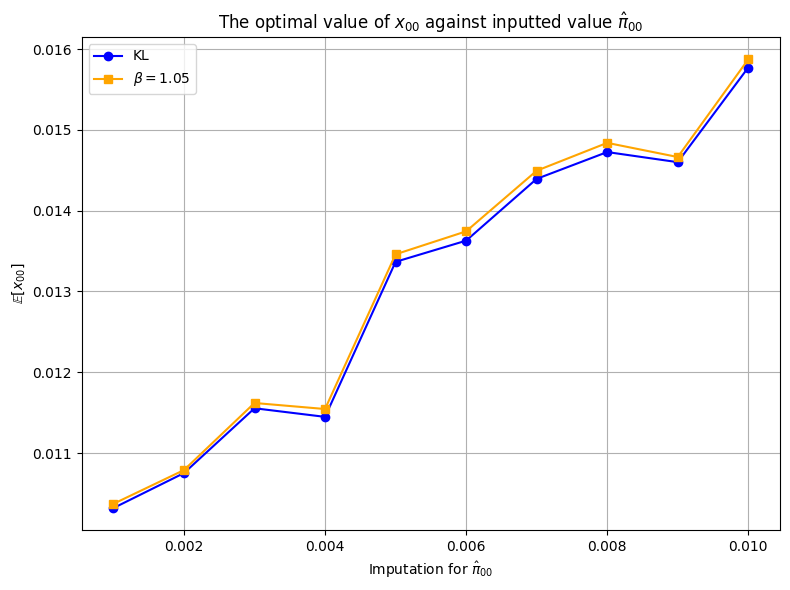

In [20]:
# Mean [0,0] comparison (two curves only) and save in current directory
plt.figure(figsize=(8, 6))
plt.plot(eps_range, stats['kl_mean00'], 'o-', label='KL', color='blue')
b = beta_list[0]
plt.plot(eps_range, stats['beta_mean00'][b], marker='s', linestyle='-', label=rf'$\beta={b}$', color='orange')
plt.xlabel(r'Imputation for $\hat\pi_{00}$')
plt.ylabel(r'$\mathbb{E}[x_{00}]$')
plt.title(r'The optimal value of $x_{00}$ against inputted value $\hat\pi_{00}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mean_x00_vs_pi_hat00_low.png')
plt.show()
plt.close()

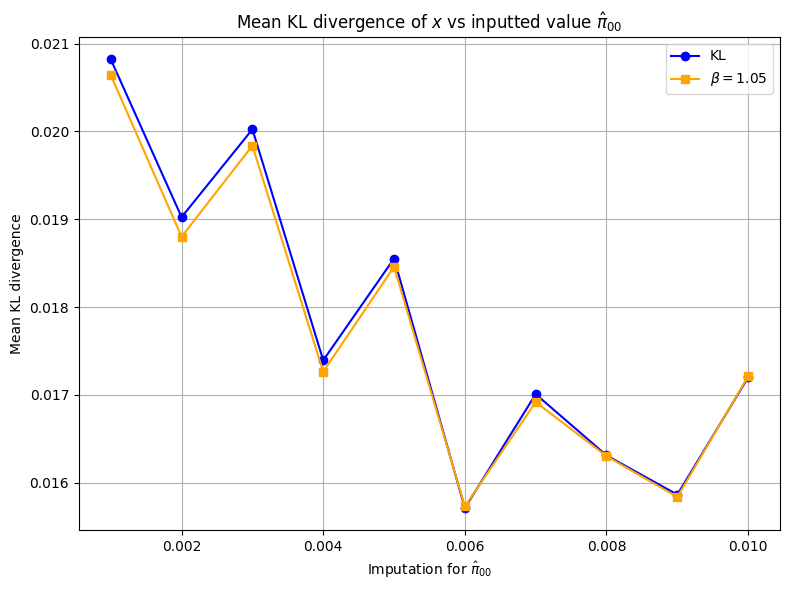

In [21]:
# Mean KL divergence comparison (two curves only) and save in current directory
plt.figure(figsize=(8, 6))
plt.plot(eps_range, stats['kl_meandiv'], 'o-', label='KL', color='blue')
plt.plot(eps_range, stats['beta_meandiv'][b], marker='s', linestyle='-', label=rf'$\beta={b}$', color='orange')
plt.xlabel(r'Imputation for $\hat\pi_{00}$')
plt.ylabel(r'Mean KL divergence')
plt.title(r'Mean KL divergence of $x$ vs inputted value $\hat\pi_{00}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mean_KL_vs_pi_hat00_low.png')
plt.show()
plt.close()